# Objective Functions

In [1]:
import IMP
import IMP.bff

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [2]:
dt = 0.0141 # time resolution (bin width of decay histogram)

fns = {
    "lintable": IMP.bff.get_example_path("spectroscopy/hgbp1/eTCSPC_whitelight.txt"),
    "irf": IMP.bff.get_example_path("spectroscopy/hgbp1/eTCSPC_Prompt.txt"),
    "donor": IMP.bff.get_example_path("spectroscopy/hgbp1/eTCSPC_Donor.txt"),
    "fret": IMP.bff.get_example_path("spectroscopy/hgbp1/eTCSPC_FRET.txt")
}

data = dict()
for key in fns:
    df = pd.read_csv(fns[key], skiprows=6, sep='\t')
    data[key] = IMP.bff.DecayCurve(x=df['Chan'] * dt, y=df['Data'])

In [3]:
class objective(object):
    
    def __init__(
        self, 
        data: IMP.bff.DecayCurve,
        irf: IMP.bff.DecayCurve,
        linearization_table: IMP.bff.DecayCurve,
        lifetime_settings: dict,
        convolution_settings: dict,
        pile_up_settings: dict,
        background_settings: dict,
        dnl_settings: dict,
        scale_settings: dict,
        score_settings: dict
    ):
        self.data = data
        self.model = IMP.bff.DecayCurve(x=data.x)
        self.lifetime_handler = IMP.bff.DecayLifetimeHandler(**lifetime_settings)
        self.convolve = IMP.bff.DecayConvolution(
            lifetime_handler=self.lifetime_handler,
            **convolution_settings
        )
        self.pile_up = IMP.bff.DecayPileup(data, **pile_up_settings)
        self.bg = IMP.bff.DecayPattern(**background_settings)
        self.dnl = IMP.bff.DecayLinearization(linearization_table, **dnl_settings)
        self.scale = IMP.bff.DecayScale(data, **scale_settings)
        self.score = IMP.bff.DecayScore(self.model, data, **score_settings)

    def __call__(self, *args, **kwargs):
        self.convolve.add(self.model)
        self.pile_up.add(self.model)
        self.bg.add(self.model)
        self.dnl.add(self.model)
        self.scale.add(self.model)
        self.score.set_model(self.model)
        return self.score.score


settings = {
    "dnl_settings": {
        "start": 0, "stop": -1,
        "n_window": 20
    },
    "background_settings": {
        "start": 0, "stop": -1,
        "constant_offset": 2.,
        "pattern": None,
        "pattern_fraction": 0.0,
        "active": True
    },
    "pile_up_settings": {
        "active": False
    },
    "convolution_settings": {
        "start": 100, "stop": 3800,
        "instrument_response_function": data["irf"],
        "convolution_method": IMP.bff.DecayConvolution.FAST,
        "excitation_period": 100,
        "irf_shift_channels": 0.0,
        "irf_background_counts": 0.0,
    },
    "lifetime_settings": {
        'lifetime_spectrum': [0.8, 4.0, 0.2, 2.0],
        'abs_lifetime_spectrum': False,   # True -> take abs of liftime spectrum
        'use_amplitude_threshold': False, # True -> discriminate lifetimes below threshold
        'amplitude_threshold': 0.0
    },
    "scale_settings": {
        "start": 0, "stop": -1,
        "constant_background": 0.0,
        "active": True,
        "blank_outside": True
    },
    "score_settings": {
        "score_type": "poisson",
        "start": 0, "stop": -1    
    }
}

In [4]:
ob = objective(
    data["donor"],
    data["irf"],
    data["lintable"],
    **settings
)
ob()

232978.91261432835

/opt/tljh/user/envs/dev/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/tljh/user/envs/dev/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


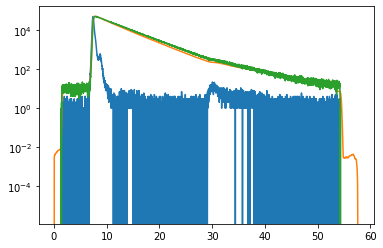

In [5]:
plt.semilogy(ob.convolve.irf.x, ob.convolve.irf.y)
plt.semilogy(ob.model.x, ob.model.y)
plt.semilogy(ob.data.x, ob.data.y)
plt.show()